# Putting it all together

## The key concepts of statistics

See also [the essential concepts of statistics](https://www.graphpad.com/support/faqid/1486/)

* Many statistical terms are also **ordinary words**
* Statistics helps you make **general conclusions** from limited data
* Statistical conclusions are always presented in terms of **probability**
* All statistical tests are based on **assumptions**
* The **SD and SEM** are quite different
* **CIs** quantifies precision
* Every P value tests a **null hypothesis**
* The **sample size** has a huge effect on the P value
* "**Statistically significant**" does not mean the effect is large or scientifically important
* "**Not statistically significant**" does not mean the effect is absent, small, or scientifically irrelevant
* The concept of statistical significance is designed to help you make a **decision** based on one result
* **Multiple comparison**s make it hard to interpret statistical results
* **Correlation** does not prove causation
* **Published statistics** tend to be optimistic
* Decisions about how to analyze data should be made **in advance**
* Statistics is only **part of interpreting** data
* Statistical calculations are helpful, but should not augment (not replace) **looking at graphs** of the data

## Statistical traps to avoid

1. Focusing on P values and statistical significance rather than effect size
2. Testing hypotheses suggested by the data
3. Analyzing without a plan - "P-hacking"
4. Making a conclusion about causation when the data only show correlation
5. Overinterpreting studies that measure a proxy or surrogate outcome
6. Overinterpreting data from an obserevation study
7. Making conclusions about individuals when the data were only collected for groups
8. Focusing only on means without asking about variability or unusual values
9. Comparing statistically singificant with not statistically significant
10. Missing important findings because data combine populations
11. Invalid multiple regression analyses as a result of an omitted variable
12. Overfitting
13. Mixing up the significance level with the FPRP
14. Not recognizing how common false positive findings are
15. Not realizing how likely it is that a "significant" conclusions from a speculative experiment is a false positive
16. Not realizing that many published studies have little statistical power
17. Trying to detect small signals when there is lots of noise
18. Unnecessary dichotomizing
19. Inflating sample size by pseudoreplication

## Capstone example

The case of the eight naked $\mathrm{IC_{50}}$.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import pingouin as pg

In [77]:
# IC50 values in nM
tmq = np.array([5.5, 12, 19, 47])
mtx = np.array([0.83, 1.1, 1.9, 5.8])

tmq_std = tmq.std(ddof=1)
mtx_std = mtx.std(ddof=1)

print(f"SD for `tmq` = {tmq_std:.1f}")
print(f"SD for `mtx` = {mtx_std:.2f}")

print(stats.describe(tmq))
print(stats.describe(mtx))

SD for `tmq` = 18.3
SD for `mtx` = 2.31
DescribeResult(nobs=4, minmax=(5.5, 47.0), mean=20.875, variance=333.7291666666667, skewness=0.8517015328954141, kurtosis=-0.8933084062681806)
DescribeResult(nobs=4, minmax=(0.83, 5.8), mean=2.4074999999999998, variance=5.321558333333333, skewness=1.0269271449617998, kurtosis=-0.7770708873536587)


In [50]:
pg.ttest(tmq, mtx)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.005884,6,two-sided,0.091676,"[-4.06, 41.0]",1.418374,1.359,0.392929


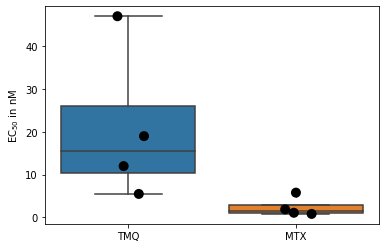

In [64]:
sns.boxplot(data=[tmq, mtx])
sns.stripplot(data=[tmq, mtx], color='k', size=10)
plt.xticks([0,1], ['TMQ', 'MTX'])
plt.ylabel("$\mathrm{EC_{50}}$ in nM");

### One-tailed t test

In [52]:
pg.ttest(tmq, mtx, alternative='less')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.005884,6,less,0.954162,"[-inf, 36.36]",1.418374,0.368,0.000273


### Equal SDs

In [78]:
ratio_var = tmq_std / mtx_std # ratio of the variances of the two groups
print(f"The `tmq` individuals have an SD {ratio_var:.2f} times larger than that of `mtx`")

F_ratio = ratio_var**2
print(f"F ratio = {F_ratio:5.3f}")

p_val = 2 * (1 - stats.f.cdf(F_ratio, len(tmq)-1, len(mtx)-1)) # for two-sided (see Crawley, the R book, p.355)
print(f"P value for the F-test of equal variance={p_val:.4f}")

The `tmq` individuals have an SD 7.92 times larger than that of `mtx`
F ratio = 62.713
P value for the F-test of equal variance=0.0066


In [47]:
print(pg.homoscedasticity([tmq, mtx], method='bartlett')) #test statistic W for Levene (using F-distribution), T for Bartlett (chi²)
print(pg.homoscedasticity([tmq, mtx], method='levene'))

                 T     pval  equal_var
bartlett  7.158623  0.00746      False
               W      pval  equal_var
levene  2.537678  0.162266       True


In [54]:
pg.ttest(tmq, mtx, correction=True) # we force correction to unequal variance as Levene method shows equal variance

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.005884,3.09565,two-sided,0.135702,"[-10.33, 47.26]",1.418374,1.359,0.392929


### Unpaired t test as linear or nonlinear regression

In [55]:
data = pd.DataFrame(
    {
        'X':[0]*len(tmq) + [1]*len(mtx),
        'y':np.concatenate([tmq, mtx])
    }
)

data

,X,y
0,0,5.50
1,0,12.00
2,0,19.00
3,0,47.00
4,1,0.83
5,1,1.10
6,1,1.90
7,1,5.80


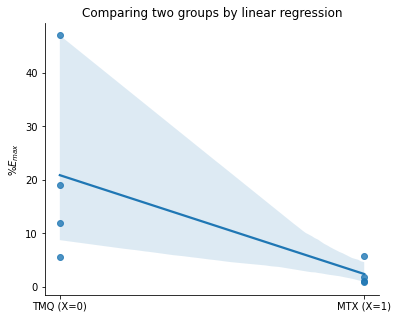

In [66]:
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x='X', y='y', data=data, ax=ax)
plt.xticks([0,1], ['TMQ (X=0)', 'MTX (X=1)'])
plt.xlabel('')
plt.ylabel("$\%E_{max}$")
plt.title("Comparing two groups by linear regression")
sns.despine();

In [67]:
lm = pg.linear_regression(X=data['X'], y=data['y'])
lm.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,20.875,6.510,3.207,0.018,0.401,0.302,4.945,36.805
1,X,-18.468,9.207,-2.006,0.092,0.401,0.302,-40.995,4.060


### Weighted linear regression

The three approaches to weighting that will be used are among those outlined [here](https://onlinecourses.science.psu.edu/stat462/node/186) (one of the approaches is modified slightly).

In [88]:
import statsmodels.formula.api as smf 

model_ols = smf.ols("y ~ X", data=data).fit() 
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     4.024
Date:                Fri, 08 Oct 2021   Prob (F-statistic):             0.0917
Time:                        12:48:53   Log-Likelihood:                -30.733
No. Observations:                   8   AIC:                             65.47
Df Residuals:                       6   BIC:                             65.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.8750      6.510      3.207      0.0

C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [92]:
# fitted values (need a constant term for intercept)
model_fitted_y = model_ols.fittedvalues
# model residuals
model_residuals = model_ols.resid
# normalized residuals
model_norm_residuals = model_ols.get_influence().resid_studentized_internal
# absolute residuals
model_abs_resid = np.abs(model_residuals)

C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


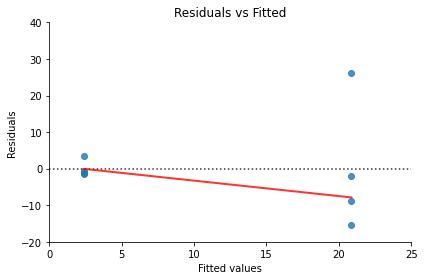

In [103]:
plot_lm_1 = plt.figure(1)
plot_lm_1.axes[0] = sns.residplot(
    model_fitted_y, 'y', data=data,
    lowess=True,
    #scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8}
)
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

plt.xlim((0,25))
plt.ylim((-20, 40))
plt.tight_layout()
sns.despine();

In [91]:
# The weight here is the inverse of the fitted values obtained from the OLS model
import statsmodels.api as sm

# An interecept is not included by default, so we have to add it manually
y=data["y"]
y=y.tolist()
X=data["X"]
X=X.tolist()
## add a intercept point
X = sm.add_constant(X)

model_fitted_y = model_ols.fittedvalues
data["weight_1"] = model_fitted_y
data["weight_1"] = data["weight_1"]**-1
model_wls_1 = sm.WLS(y, X, data['weight_1'])
mod_res_1 = model_wls_1.fit()
print(mod_res_1.summary())


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            WLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     6.440
Date:                Fri, 08 Oct 2021   Prob (F-statistic):             0.0442
Time:                        12:53:06   Log-Likelihood:                -26.868
No. Observations:                   8   AIC:                             57.74
Df Residuals:                       6   BIC:                             57.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8750      6.891      3.029      0.0

C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [110]:
# Here we regress the absolute values of the residuals against the predictor
data["temp"] = model_abs_resid
model_temp = smf.ols("temp ~ X", data=data).fit()
weight_2 = model_temp.fittedvalues
weight_2 = weight_2**-2
data['weight_2'] = weight_2

mod_wls = sm.WLS(y, X, data['weight_2'])
mod_res = mod_wls.fit()
print(mod_res.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.408
Model:                            WLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     4.132
Date:                Fri, 08 Oct 2021   Prob (F-statistic):             0.0883
Time:                        13:05:38   Log-Likelihood:                -25.167
No. Observations:                   8   AIC:                             54.33
Df Residuals:                       6   BIC:                             54.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8750      9.009      2.317      0.0

C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [111]:
# Here we regress the squared residuals against the predictor
data["temp"] = model_residuals**2
model_temp = smf.ols("temp ~ X", data=data).fit()
weight_3 = model_temp.fittedvalues
weight_3 = abs(weight_3)
weight_3 = weight_3**-1
data['weight_3'] = weight_3

mod_wls = sm.WLS(y, X, data['weight_3'])
mod_res = mod_wls.fit()
print(mod_res.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.401
Model:                            WLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     4.024
Date:                Fri, 08 Oct 2021   Prob (F-statistic):             0.0917
Time:                        13:06:12   Log-Likelihood:                -25.165
No. Observations:                   8   AIC:                             54.33
Df Residuals:                       6   BIC:                             54.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8750      9.134      2.285      0.0

C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [113]:
# Same as in the book, with weighting with the reciprocal of the square of the predicted y
data["weight_4"] = model_fitted_y**-2
model_wls_4 = sm.WLS(y, X, data['weight_4'])
mod_res_4 = model_wls_4.fit()
print(mod_res_4.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.379
Model:                            WLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     3.669
Date:                Fri, 08 Oct 2021   Prob (F-statistic):              0.104
Time:                        13:09:51   Log-Likelihood:                -25.181
No. Observations:                   8   AIC:                             54.36
Df Residuals:                       6   BIC:                             54.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8750      9.577      2.180      0.0

C:\Users\WIECKOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Nonparametric Mann-Whitney test

Normality tests are rarely helpful when used as part of an analysis of a particular experiment, it should be preferred to collect many values (dozens to hundreds) while characterizing an experimental assay, and then examine the distribution of these values using various test, including normality tests to decide how these kinds of data should be analyzed. That decision then applies to all experiments that use the assay.

In [115]:
import pingouin as pg

pg.mwu(tmq, mtx, method='exact', alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,15.0,two-sided,0.057143,-0.875,0.9375


### Increase sample size

Remind than for unpaired values, the Cohen $d$ equals 

$$ d = \frac{\overline{X} - \overline{Y}}{\sqrt{\frac{(n_{1} - 1)\sigma_{1}^{2} + (n_{2} - 1) \sigma_{2}^{2}}{n1 + n2 - 2}}} $$

For a comparison between 2 groups with the same sample size ($n_1 = n_2 = n$) but different variance values $\sigma_1^2 \neq \sigma_2^2$, the equation can be simplified to

$$ d = \frac{\overline{X} - \overline{Y}}{\sqrt{\frac{(n - 1)(\sigma_1^2 + \sigma_2^2)}{2 (n - 1)}}} = \frac{\overline{X} - \overline{Y}}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}} $$

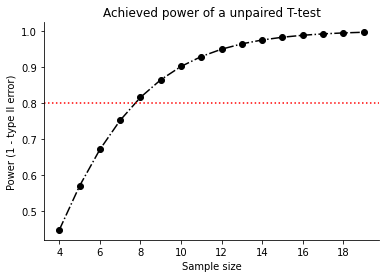

In [119]:
min_mean_diff = 20 # a bit higher than observed
s = np.sqrt(np.mean([tmq_std**2, mtx_std**2]))
d = min_mean_diff / s
n = np.arange(4, 20)  # Incrementing sample size

# Compute the achieved power
pwr = pg.power_ttest(d=d, n=n, contrast='two-samples', alternative='two-sided')

# Plotting
plt.plot(n, pwr, 'ko-.')
plt.axhline(0.8, color='r', ls=':')
plt.xlabel('Sample size')
plt.ylabel('Power (1 - type II error)')
plt.title('Achieved power of a unpaired T-test')
sns.despine()

In [129]:
#Compute required sample size given d, power and alpha
pg.power_ttest(d=d, power=0.8, contrast='two-samples', alternative='two-sided')

7.741973852441344

### Lognormal data

In [137]:
tmq_log = np.log10(tmq)
mtx_log = np.log10(mtx)

tmq_log_std = tmq_log.std(ddof=1)
mtx_log_std = mtx_log.std(ddof=1)

print(f"SD for log(`tmq`) = {tmq_log_std:.3f}")
print(f"SD for log(`mtx`) = {mtx_log_std:.3f}")

print(stats.describe(tmq_log))
print(stats.describe(mtx_log))

print(f"Geometric mean for `tmq` = {10**tmq_log.mean():.2f} nM")
print(f"Geometric mean for `mtx` = {10**mtx_log.mean():.2f} nM")

SD for log(`tmq`) = 0.389
SD for log(`mtx`) = 0.373
DescribeResult(nobs=4, minmax=(0.7403626894942439, 1.6720978579357175), mean=1.1925988486076038, variance=0.15157434582612236, skewness=0.11046645653536111, kurtosis=-1.163960323879744)
DescribeResult(nobs=4, minmax=(-0.08092190762392612, 0.7634279935629372), mean=0.25066309301251627, variance=0.13915321204113287, skewness=0.6615634785142156, kurtosis=-1.091763840545427)
Geometric mean for `tmq` = 15.58 nM
Geometric mean for `mtx` = 1.78 nM


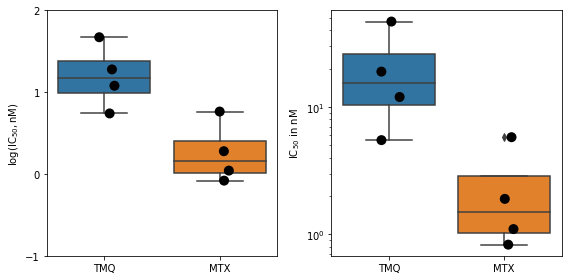

In [146]:
plt.figure(figsize=(8,4))
plt.subplot(121)
sns.boxplot(data=[tmq_log, mtx_log])
sns.stripplot(data=[tmq_log, mtx_log], color='k', size=10)
plt.xticks([0,1], ['TMQ', 'MTX'])
plt.yticks([-1, 0, 1, 2])
plt.ylabel("$\log(\mathrm{IC_{50}}\mathrm{, nM})$")

plt.subplot(122)
sns.boxplot(data=[tmq, mtx])
sns.stripplot(data=[tmq, mtx], color='k', size=10)
plt.yscale('log')
plt.xticks([0,1], ['TMQ', 'MTX'])
plt.ylabel("$\mathrm{IC_{50}}$ in nM")

plt.tight_layout();

In [149]:
ttest_log = pg.ttest(tmq_log, mtx_log)
ttest_log.round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.49,6,two-sided,0.01,"[0.28, 1.6]",2.47,4.393,0.83


In [155]:
diff_log_means = abs(tmq_log.mean() - mtx_log.mean())
print(f"The difference between the log(means) = {diff_log_means:.3f} which corresponds to a potency ratio of {10**diff_log_means:.2f}")
print(f"And the 95% CI of the potency ratio ranging from {10**ttest_log.loc['T-test', 'CI95%'][0]:.2f} to {10**ttest_log.loc['T-test', 'CI95%'][1]:.2f}")

The difference between the log(means) = 0.942 which corresponds to a potency ratio of 8.75
And the 95% CI of the potency ratio ranging from 1.91 to 39.81


### Sample size calculations revisited

Note that the power from the last t-test was greater than 0.8.

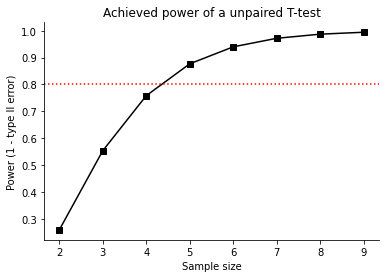

In [170]:
min_mean_diff_log = np.log10(8) # eightfold difference in potency
s_log = 0.40 # because the SD was comparable for the lognormal values
d_log = min_mean_diff_log/ s_log
n = np.arange(2, 10)  # Incrementing sample size

# Compute the achieved power
pwr_log = pg.power_ttest(d=d_log, n=n, contrast='two-samples', alternative='two-sided')

# Plotting
plt.plot(n, pwr_log, 'ks-', ms=6)
plt.axhline(0.8, color='r', ls=':')
plt.xlabel('Sample size')
plt.ylabel('Power (1 - type II error)')
plt.title('Achieved power of a unpaired T-test')
sns.despine()

In [157]:
pg.power_ttest(d=d_log, power=0.8, contrast='two-samples', alternative='two-sided')

4.289295994250316

### Simulations

Simulating data is a powerful tool that can reveal deep insights into data analysis approaches. Learning to simulate data is not hard, and it is a skill well worth acquiring if you plan to design experiments and analyze scientific data. And you can save a lot of time in the lab by using simulations to test the design of your experiments.

For the example above, because the violation of all thress assumptions (lognormal distribution, unequal variance and differences examined rather than ratios) discourages the use of the standard t test on untransformed $\mathrm{IC_{50}}$ values, this approach has much less statistical power (43.0% vs.  83.6%).

In [214]:
np.random.seed(111)
mean_1, mean_2         = 2, 20 # 2 and 20 nM corresp to MTX and TMQ
mean_log_1, mean_log_2 = np.log10(mean_1), np.log10(mean_2)
sd_log                 = 0.4 # used for the ratios of the means
sd1, sd2               = 2, 18 # used for the difference of the means
obs                    = [4, 7] # number of samples in each group
sims                   = 10_000 # number of simulations

for o in obs:
	p_values     = np.array([])
	p_values_log = np.array([])

	sample_1     = stats.norm(loc=mean_1, scale=sd1)
	sample_2     = stats.norm(loc=mean_2, scale=sd2)

	sample_1_log = stats.norm(loc=mean_log_1, scale=sd_log)
	sample_2_log = stats.norm(loc=mean_log_2, scale=sd_log)

	for _ in range(sims):
		# t test for untransformed values
		stat, p_value = stats.ttest_ind(sample_1.rvs(size=o), sample_2.rvs(size=o))
		p_values = np.append(p_values, p_value)

		# t test for lognormal values
		stat, p_value = stats.ttest_ind(sample_1_log.rvs(size=o), sample_2_log.rvs(size=o))
		p_values_log = np.append(p_values_log, p_value)

	print(f"For {sims} simulations and n = {o} in each group:")
	print(f"Proportion of experiments with P<0.05 is {100 * sum(p_values<0.05) / len(p_values):.1f}% for untransformed values")
	print(f"Proportion of experiments with P<0.05 is {100 * sum(p_values_log<0.05) / len(p_values):.1f}% for lognormal values")
	print("------------------------------------------")

For 10000 simulations and n = 4 in each group:
Proportion of experiments with P<0.05 is 43.0% for untransformed values
Proportion of experiments with P<0.05 is 83.6% for lognormal values
------------------------------------------
For 10000 simulations and n = 7 in each group:
Proportion of experiments with P<0.05 is 67.4% for untransformed values
Proportion of experiments with P<0.05 is 99.1% for lognormal values
------------------------------------------


In other words, these numbers show the **power** of the experimental design, i.e. the number of experiments that show statistical significance knowing that the true effect is real (the null hypotesis is false).

Increasing the sample size to n=7 increases the power to 67.4% for the t test of the untransformed values. However, it also barely changes the Type I error rates.

In [224]:
np.random.seed(111)
mean         = 20 # same mean
mean_log     = np.log10(mean)
sd_log       = 0.4 # used for the ratios of the means
sd           = 20 # used for the difference of the means
obs          = [4, 7] # number of samples in each group
sims         = 50_000 # number of simulations

for o in obs:
	p_values     = np.array([])
	p_values_log = np.array([])

	sample_1     = stats.norm(loc=mean, scale=sd)

	sample_1_log = stats.norm(loc=mean_log, scale=sd_log)

	for _ in range(sims):
		# t test for untransformed values
		stat, p_value = stats.ttest_ind(sample_1.rvs(size=o), sample_1.rvs(size=o))
		p_values = np.append(p_values, p_value)

		# t test for lognormal values
		stat, p_value = stats.ttest_ind(sample_1_log.rvs(size=o), sample_1_log.rvs(size=o))
		p_values_log = np.append(p_values_log, p_value)

	print(f"For {sims} simulations and n = {o} in each group:")
	print(f"Proportion of experiments with P<0.05 is {100 * sum(p_values<0.05) / len(p_values):.1f}% for untransformed values")
	print(f"Proportion of experiments with P<0.05 is {100 * sum(p_values_log<0.05) / len(p_values):.1f}% for lognormal values")
	print("------------------------------------------")

For 50000 simulations and n = 4 in each group:
Proportion of experiments with P<0.05 is 4.8% for untransformed values
Proportion of experiments with P<0.05 is 5.0% for lognormal values
------------------------------------------
For 50000 simulations and n = 7 in each group:
Proportion of experiments with P<0.05 is 4.8% for untransformed values
Proportion of experiments with P<0.05 is 5.1% for lognormal values
------------------------------------------


## Checklist for reporting statistical methods and results

You may also want to consult similar guides by [Curtis and colleagues (2015)](https://pubmed.ncbi.nlm.nih.gov/29520785/) and by [Altman and colleagues (1983)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1547706/).

### Reporting methods used for data analysis

- Reporting the analyses before the analyses: normalization, logarithms, smoothing, baseline, outliers -> explain
- Reporting sample size: different animals or technical replicates?
- Reporting use of statistical tests: full name of the test, options selected, programs and versions used and if possible post the scripts or analysis steps
- Reporting planning (or lack of planning) of analyses: state if and how the analyses were planned

### Graphing data

- General principles: present the data clearly, with enough details; consider posting the raw data for reproducibility
- Graphing variability: when possible, graph individual data, not summary of the data

### Reporting statistical results

- Reporting and graphing effect size: how big was the difference, how strongly were the variables correlated. Report with a CI
- Reporting P values: use a number rather than an inequality, clearly state the null hypothesis if there is any possible ambiguity; one- or two-sided?
- Reporting statistical hypothesis testing: report the preset threshold P value and the model
  - If not making a decision based on P value, then the idea of statistical hypothesis isn't useful, report effect with its CI
  - Use _large, substantial, relevant_ when discussing the biological impact of a results instead of _significant_
- Reporting regression results with one independent variable: what model you fit to the data, with all details about the parameters and assumptions
  - Report the best-fit values with their CIs
  - Consider reporting the covariation matrix to show how independent or interwined the parameters are
  - Consider also graphing the confidence bands
  - Report goodness of fit (sum-of-squares, SD of residuals, $R^2$ or all three)
- Reporting regression results with multiple independent variables: all points above + show Y values predicted by the model
- Reporting multiple comparisons: all steps must be documented, follow-up testing after ANOVA


## Choosing a statistical test

### Continuous data from **normal/Gaussian distribution** (biological measures, etc.)

- Test Gaussian assumption
  - **normality** tests
  - **outliers** tests
- Describe one sample
  - **frequency** distribution
  - sample **mean**
  - sample **SD**
  - minimum and maximum value, **range**
  - 25th and 75th **percentiles**
- Inference about one population
  - **one-sample t** test
- Compare two unmatched groups
  - **unpaired t** test
- Compare two matched groups
  - **paired t** test
- Compare three or more unmatched groups
  - **one-way ANOVA** + multiple comparisons tests
- Compare three or more matched groups
  - **repeated-measures ANOVA** + multiple comparisons tests
- Quantify association between two variables
  - **Pearson**'s correlation
- Explain/predict one variable from another
  - simple **linear regression** (single independent variable)
  - simple **nonlinear regression**
- Explain/predict one variable from several others
  - **multiple linear** regression (more than one independent variables)
  - **multiple nonlinear** regression

### Continuous data from **non-Gaussian distribution** (or ranked data; scores, etc.)

- Describe one sample
  - **frequency** distribution
  - sample **median**
  - minimum and maximum value, **range**
  - 25th and 75th **percentiles**
- Inference about one population
  - **Wilcoxon's rank-sum** test
- Compare two unmatched groups
  - **Mann-Whitney** test
- Compare two matched groups
  - **Wilcoxon's matched pairs** test
- Compare three or more unmatched groups
  - **Kruskal-Wallis** test + Dunn's posttest
- Compare three or more matched groups
  - **Friedman**'s test
- Quantify association between two variables
  - **Spearman**'s correlation

### **Survival times** or time to an event (survival, etc.)

- Describe one sample
  - **Kaplan-Meier** surival curve
  - **median survival time**
  - 5-year survival percentage
- Inference about one population
  - **confidence bands** around survival curve
  - CI of median survival
- Compare two unmatched groups
  - **log-rank** test
  - Gehan-Breslow test
  - **CI of ratio** of median survival times
  - **CI of hazard ratio**
- Compare two matched groups
  - conditional proportional **hazards regression**
- Compare three or more unmatched groups
  - log-rank test
  - Gehan-Breslow test
- Compare three or more matched groups
  - conditional proportional hazards regression
- Explain/predict one variable from one or several others
  - **Cox's proportional hazards regression**

### **Binomial** (yes/no, etc.)

- Describe one sample
  - **proportion**
- Inference about one population
  - **CI** of proportion
  - **binomial** test to compare observed distribution with theoritical (expected) distribution
- Compare two unmatched groups
  - **Fisher**'s exact test
- Compare two matched groups
  - **McNemar**'s test
- Compare three or more unmatched groups
  - **Chi-square** test
  - Chi-square test for trend
- Compare three or more matched groups
  - **Cochran's Q**
- Explain/predict one variable from one or several others
  - **Logistic regression**